In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# utilisation de sympi pour intégrer la formule de vitesse

In [2]:
import sympy as sp


In [3]:
''' -------------------------------------------------------------------------
def velocity (x, bino, start_anti, v_anti, latence, tau, maxi) :
    v_anti = v_anti/1000 # pour passer de sec à ms
    time = x # np.arange(len(x))
    vitesse = []
    didi = (bino*2-1)
    
    for t in range(len(time)):
        x_lat = time[t]-latence
        x_start = time[t]-start_anti
        
        if start_anti >= latence :
            if time[t] < latence :
                vitesse.append(0)
            else :
                vitesse.append(didi*maxi*(1-np.exp(-x_lat/tau)))
        else :
            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    vitesse.append(x_start*v_anti)
                    y = x_start*v_anti
                else :
                    vitesse.append(didi*maxi*(1-np.exp(-x_lat/tau))+y)

    return vitesse
-------------------------------------------------------------------------------'''

x_lat, x_start, didi, v_anti, tau, maxi, y = sp.symbols(
    'x_lat,x_start, didi, v_anti, tau, maxi, y')

F1 = x_start*v_anti
F2 = didi*maxi*(1-sp.exp(-x_lat/tau))

print(F1, '->', sp.integrate(F1, x_start))
print(F2, '->', sp.integrate(F2, x_lat))

v_anti*x_start -> v_anti*x_start**2/2
didi*maxi*(1 - exp(-x_lat/tau)) -> didi*maxi*tau*exp(-x_lat/tau) + didi*maxi*x_lat


# extracting data and doing the fit on velocity

In [4]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [5]:
block = 0
trial = 131

# -----------------------------------------
N_trials = exp['N_trials']
screen_width_px = exp['screen_width_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']
# -----------------------------------------

trial_data = trial + N_trials*block

time = data[trial_data]['trackertime']
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
# [starttime, endtime, duration, startx, starty, endx, endy]
saccades = data[trial_data]['events']['Esac']
t_0 = time[0]

DATA_x = data[trial_data]['x']
data_x = DATA_x-(DATA_x[StimulusOf-t_0])
#data_x = DATA_x-(exp['screen_width_px']/2)

bino = p[trial, block, 0]

start = TargetOn
start1 = TargetOn-t_0

In [6]:
def deco(axs) :
    #axs.plot(time-start,target(time, bino, TargetOn-t_0, RashBass, V_X), '--k', alpha=0.4, linewidth=1.5)
    axs.axvspan(StimulusOn-start, StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(StimulusOf-start, TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(TargetOn-start, TargetOff-start, color='k', alpha=0.15)
    for s in range(len(saccades)) :
        axs.axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

In [7]:
def position(x, bino, start_anti, v_anti, latence, tau, maxi, nan=False, do_numpy=False):
    
    #gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
    ms = 1000
    v_anti = (v_anti/1000)/ms # pour passer de sec à ms
    maxi = maxi /ms
    direction  = (bino*2-1)
    
    if do_numpy:
        time_ = np.arange(len(x))
        acceleration = np.zeros_like(time_) * 1.
        acceleration[int(start_anti):int(latence)] = v_anti * np.ones(int(latence)-int(start_anti))
        acceleration[int(latence):] = direction*maxi/tau * np.exp(-(time_[int(latence):]-latence)/tau)
        speed = np.cumsum(acceleration)
        pos = np.cumsum(speed)
        for sacc in saccades :
            # [starttime, endtime, duration, startx, starty, endx, endy]
            print((sacc[5]-sacc[3]) , int(sacc[0]-t_0), int(sacc[1]-t_0), np.sum(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) , sacc[2])
            pos[int(sacc[1]-t_0):] += (sacc[5]-sacc[3])/ exp['px_per_deg'] - np.sum(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]            
           
    else:
        time = x
        pos = []

        if nan == True :
            avant, apres = 0, 0 #5, 10 #15
            lala = []
            for s in range(len(saccades)) :
                if saccades[s][1]-t_0+apres <= (len(time)) :
                    lala.append(saccades[s][1]-t_0+apres)
                else :
                    lala.append(len(time))

        a, s = 0, 0
        for t in range(len(time)):

            x_lat = time[t]-latence
            x_start = time[t]-start_anti

            if nan == True :
                baba = np.arange((saccades[s][0]-t_0-avant), lala[s])
            else :
                baba = np.arange(len(time)+1, len(time)+2)

            if t in baba :
                if t > 0 :
                    pos.append(np.nan)
                    a = pos[saccades[s][0]-t_0-avant-1]+((saccades[s][5]-saccades[s][3])/exp['px_per_deg'])
                else :
                    pos.append(np.nan)
                    a = 0+((saccades[s][5]-saccades[s][3])/exp['px_per_deg'])

                if t == lala[s]-1 :
                    if s < len(saccades)-1 :
                        s = s+1

            else :
                if start_anti >= latence :
                    if time[t] < latence :
                        pos.append(a)
                    else :
                        #pos.append(a + direction*maxi*(x_lat + tau*np.exp(-x_lat/tau)))
                        #pos.append(a + direction*maxi*(x_lat + (1/tau)*(np.exp(-x_lat/tau)-1))) 
                        pos.append(a + direction*maxi*(x_lat + (1/tau)*(np.exp(-x_lat/tau)))) 


                else :
                    if time[t] < start_anti :
                        pos.append(a)
                    else :
                        if time[t] < latence :
                            pos.append(a + ((v_anti*x_start**2)/2))
                            y = a + ((v_anti*x_start**2)/2)
                        else :
                            #pos.append(y + direction*maxi*(x_lat + tau*np.exp(-x_lat/tau)))
                            #pos.append(y + direction*maxi*(x_lat + (1/tau)*(np.exp(-x_lat/tau)-1)))
                            pos.append(y + direction*maxi*(x_lat + (1/tau)*(np.exp(-x_lat/tau))))

                        

    return pos

In [8]:
data = np.copy(data_x)
  
avant, apres =  5, 10 #15
for s in range(len(saccades)) :
    if saccades[s][1]-t_0+apres <= (len(time)) :
        for x_data in np.arange((saccades[s][0]-t_0-avant), (saccades[s][1]-t_0+apres)) :
            data[x_data] = np.nan
    else :
        for x_data in np.arange((saccades[s][0]-t_0-avant), (len(time))) :
            data[x_data] = np.nan
            
# data2 = np.copy(data)           
data3 = np.copy(data)
a = 0
for s in range(len(saccades)) :
    a = a + (data[saccades[s][1]-t_0+apres]-data[saccades[s][0]-t_0-avant-1])
    b = ((data[saccades[s][0]-t_0-avant-1]-data[saccades[s][0]-t_0-avant-11])/10)
    if s < len(saccades)-1 :
        for x_data in np.arange((saccades[s][1]-t_0+apres), (saccades[s+1][0]-t_0-avant)) :
            # data2[x_data] = data2[x_data]-a
            data3[x_data] = data3[x_data]-a + ((saccades[s][1]-t_0+apres)-(saccades[s][0]-t_0-avant))*b
    else :
        for x_data in np.arange((saccades[s][1]-t_0+apres), len(time)) :
            # data2[x_data] = data2[x_data]-a
            data3[x_data] = data3[x_data]-a +((saccades[s][1]-t_0+apres)-(saccades[s][0]-t_0-avant))*b
            
data3 = data3 - data3[StimulusOf-t_0]

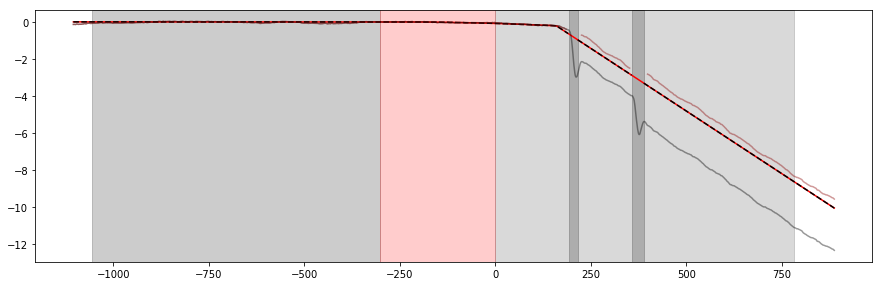

In [9]:
fig_width = 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)

a = position(np.arange(len(time)), bino, param['start_anti'][block][trial]+start1,
             param['v_anti'][block][trial], param['latence'][block][trial]+start1,
             param['tau'][block][trial], param['maxi'][block][trial]) 
axs.plot(time-start, a-np.ones(len(a))*(a[StimulusOf-t_0]), c='r', label='fit on speed')

b = position(np.arange(len(time)), bino, param['start_anti'][block][trial]+start1,
             param['v_anti'][block][trial], param['latence'][block][trial]+start1,
             param['tau'][block][trial], param['maxi'][block][trial], nan=True)
axs.plot(time-start, b-np.ones(len(b))*(b[StimulusOf-t_0]), '--k', label='fit on speed')


axs.plot(time-start, data_x / exp['px_per_deg'], color='k', alpha=0.4, label='raw position')
axs.plot(time-start, data3 / exp['px_per_deg'] , color='darkred', alpha=0.4, label='de-saccaded position');


# doing the fit

In [10]:
def Fit_position(velocity_x, trackertime, bino, param_fit=None, TargetOn=TargetOn,
                 StimulusOf=StimulusOf, saccades=saccades, sup=False, time_sup=-280, step=2,
                 nan=True) :

    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,0.,40], 'v_anti':[0.,-40.,40.], 'latence':[TargetOn-t_0+100,TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]}


    if param_fit['latence'][2]=='STOP' :
        stop_latence = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latence.append((saccades[s][0]-t_0))
        if stop_latence==[] :
            stop_latence.append(len(time))
        stop = stop_latence[0]
    else :
        stop = param_fit['latence'][2]


    if sup==True :
        velocity_x = velocity_x[:time_sup]
        trackertime = trackertime[:time_sup]

    model = Model(position)

    params = Parameters()

    if step == 1 :
        vary = True
    elif step == 2 :
        vary = False

    params.add('nan', value=nan, vary=False)
    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latence', value=param_fit['latence'][0], min=param_fit['latence'][1], max=stop)
    params.add('bino', value=bino, vary=False)
    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vary)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vary)
    params.add('v_anti', value=param_fit['v_anti'][0], min=param_fit['v_anti'][1], max=param_fit['v_anti'][2], vary=vary)

    if step == 1 :
        result_deg = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')

    elif step == 2 :
        out = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['v_anti'].set(vary=True)

        result_deg = model.fit(velocity_x, out.params, x=np.arange(len(trackertime)), method='nelder', nan_policy='omit')
                                
    return result_deg


In [ ]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
deco(axs)
#axs.plot(time-start, data_x, color='k', alpha=0.6)

#gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
data_2 = np.copy(data3) #data_x)
data_2 = data_2 * 1/exp['px_per_deg']

axs.plot(time-start, data_x / exp['px_per_deg'], color='k', alpha=0.4)
axs.plot(time-start, data3 / exp['px_per_deg'] , color='darkred', alpha=0.4)


a = Fit_position(data_2,time, bino,step=2, sup=True, time_sup=-280, nan=False)
b = position(np.arange(len(time)), bino, a.values['start_anti'], a.values['v_anti'], a.values['latence'], a.values['tau'], a.values['maxi'])
axs.plot(time-start, b-np.ones(len(b))*(b[StimulusOf-t_0]) , c='r')

c = Fit_position(data_2,time, bino,step=2, sup=True, time_sup=-280, nan=True)
d = position(np.arange(len(time)), bino, c.values['start_anti'], c.values['v_anti'],
             c.values['latence'], c.values['tau'], c.values['maxi'], nan=True)
axs.plot(time-start, d-np.ones(len(d))*(d[StimulusOf-t_0]) , '--k');

In [ ]:
print('start_anti : %0.3f    a -> %0.3f, c -> %0.3f'%(param['start_anti'][block][trial], a.values['start_anti']-start1, c.values['start_anti']-start1), 
      '\nv_anti : %0.3f    a -> %0.3f, c -> %0.3f'%(param['v_anti'][block][trial], a.values['v_anti'], c.values['v_anti']), 
      '\nlatence : %0.3f    a -> %0.3f, c -> %0.3f'%(param['latence'][block][trial], a.values['latence']-start1, c.values['latence']-start1),
      '\ntau : %0.3f    a -> %0.3f, c -> %0.3f'%(param['tau'][block][trial], a.values['tau'], c.values['tau']),
      '\nmaxi : %0.3f    a -> %0.3f, c -> %0.3f'%(param['maxi'][block][trial], a.values['maxi'], c.values['maxi']))

# integrating in ANEMO

````
from ANEMO import ANEMO

import lmfit
from lmfit import Model, Parameters
lmfit.__version__
````